### Libraries

In [1]:
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
import texthero as hero
from texthero import preprocessing
from texthero import stopwords
sb.set() # set the default Seaborn style for graphics
from matplotlib.ticker import FuncFormatter, MaxNLocator
import matplotlib.dates as mdates

### Chunking CSV to upload onto GitHub

import pandas as pd

chunk_size = 55000
batch_no = 1

for chunk in pd.read_csv('221100_DayZ.csv', chunksize=chunk_size):
    #chunk.to_csv('221100_DayZ' + str(batch_no) + '.csv', index=False)
    #batch_no +=1

### Dataset

In [2]:
steamData = pd.read_csv('steam_data/steam.csv')
#steamSupportInfo = pd.read_csv('steam_data/steam_support_info.csv')
#steamChart = pd.read_csv('steam_data/steamCharts.csv')
#steamSpyTagData = pd.read_csv('steam_data/steamspy_tag_data.csv')
steamGames = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_games/steam_games*.csv"))))
#steamMediaData = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_media_data/steam_media_data*.csv"))))
#steamRequirements = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_requirements/steam_requirements*.csv"))))
#steamDescription = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_description/steam_description*.csv"))))

#game reviews
#steam_HalfOfTheGameReviews = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_reviews/steam_review_*.csv"))))
#files = glob.glob("steam_data/steam_reviews" + '**/**' + "/*.csv")
#steamReviews_fromFolder = pd.concat([pd.read_csv(f) for f in files ])
#steamReviewsDF = [steam_HalfOfTheGameReviews, steamReviews_fromFolder]
#steamCombinedReviews = pd.concat(steamReviewsDF)


#game reviews
firstHalfReviewFiles =glob.glob(os.path.join('', "steam_data/steam_reviews/steam_review_*.csv"))
secondHalfReviewFiles = glob.glob("steam_data/steam_reviews" + '**/**' + "/*.csv")
allReviewFiles = firstHalfReviewFiles + secondHalfReviewFiles
print(len(allReviewFiles))

191


### Cleaning the Dataset

##### renaming and getting the columns we need

In [3]:
#rename for easier identification
steamGames = steamGames.rename(columns={"name": "title"})
steamData = steamData.rename(columns={"name": "title", "genres":"genre"})

#drop columns
steamGames = steamGames[["title", "genre","release_date"]]
steamData = steamData[['title', 'genre', 'release_date','owners','positive_ratings', 'negative_ratings','price']]

#Check got any NA, if got drop
#steamGames.isna().sum()
#steamGames[steamGames['title'].isnull()]
steamGames = steamGames.dropna()

#steamData.isna().sum()

#####  text processing using texthero

In [4]:
# #text processing for reviews
# default_stopwords = stopwords.DEFAULT
# custom_stopwords = default_stopwords.union(set(["game","mods","/"]))

# custom_pipeline_review = [preprocessing.fillna
#                           , preprocessing.lowercase
#                           , preprocessing.remove_punctuation
#                           , preprocessing.remove_diacritics
#                           , preprocessing.remove_whitespace
#                           ,preprocessing.remove_digits]
#                           #, preprocessing.drop_no_content]

In [5]:
#text processing for title
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace]

steamGames['title'] = hero.clean(steamGames['title'], pipeline = custom_pipeline)
steamData['title'] = hero.clean(steamData['title'], pipeline = custom_pipeline)

In [6]:
# def chunks(lst, n):
#     #Yield successive n-sized chunks from lst
#     for i in range(0, len(lst), n):
#         yield lst[i:i + n]

# listofDF = list()
# for files in chunks(allReviewFiles,20):
#     reviewsDF = pd.concat([pd.read_csv(f, encoding = "ISO-8859-1", engine='python') for f in files])
#     reviewsDF = reviewsDF[["title", "review","voted_up"]]
#     reviewsDF = reviewsDF.reset_index(drop=True)
    
    
    
#     titleSerie = hero.clean(reviewsDF.title, pipeline = custom_pipeline)
#     reviewSerie = hero.clean(reviewsDF.review, pipeline=custom_pipeline_review)
#     reviewSerie = hero.remove_stopwords(reviewSerie, custom_stopwords)
#     voteSerie = reviewsDF[["voted_up"]]
    
    
#     reviewsTitle = pd.concat([titleSerie, reviewSerie, voteSerie], axis=1).reset_index(drop=True)

#     listofDF.append(reviewsTitle)

In [7]:
#reviewTitleDF = pd.concat(listofDF)

In [ ]:
#reviewTitleDF.title.unique()

##### stored clean reviewTitle df in HDFStore as processing take about 11 minutes

In [ ]:
store = pd.HDFStore('store.h5')
#store['reviewTitleDF'] = reviewTitleDF  # save it

In [ ]:
#this take a while to load also but faster than processing
storedReviewsTitleDF = store['reviewTitleDF'] #load it

In [ ]:
cleanReviewsTitle = storedReviewsTitleDF.rename(columns={"review": "clean_review"})
#cleanReviewsTitle

#convert any blank row to na and drop them
cleanReviewsTitle = cleanReviewsTitle.replace(r'^\s+$', np.nan, regex=True)

#cleanReviewsTitle.isna().sum()
#cleanReviewsTitle[cleanReviewsTitle['voted_up'].isnull()]
cleanReviewsTitle = cleanReviewsTitle.dropna()
cleanReviewsTitle = cleanReviewsTitle.reset_index()

# cleanReviewsTitle.isna().sum()
# cleanReviewsTitle.isnull().values.any()

##### putting the data into another dataframe 

In [ ]:
# steamGames_Title_Genre = steamGames
# steamData_Title_Rating = steamData

##### matching title

In [ ]:
# #Genre
# matchTitleGenre = steamGames_Title_Genre.title.isin(cleanReviewsTitle.title)
# steamMatchTitleGenre = steamGames_Title_Genre[matchTitleGenre]
# steamUniqueTitleGenre = steamMatchTitleGenre

# #Rating
# matchTitleRating = steamData_Title_Rating.title.isin(cleanReviewsTitle.title)
# steamMatchTitleRating = steamData_Title_Rating[matchTitleRating]
# steamUniqueTitleRating = steamMatchTitleRating

In [98]:
steamUniqueTitleGenre = steamGames
steamUniqueTitleRating = steamData

In [99]:
gen_cols = [
        'Action',
        'Adventure',
        'Casual',
        'Indie',
        'Massively Multiplayer',
        'RPG',
        'Racing',
        'Simulation',
        'Sports',
        'Strategy'
    ]
    
gen_col_names = []

for col in sorted(gen_cols):
    col_name = col.lower().replace('&', 'and').replace(' ', '_')
    gen_col_names.append(col_name)
        
    steamUniqueTitleGenre[col_name] = steamUniqueTitleGenre['genre'].apply(lambda x: 1 if col in x.split(',') else 0)
        # alternate method using np.where:
        # df[col_name] = np.where(df['genres'].str.contains(col), 1, 0)
    
    # remove "non-games" based on genre
    # if a row has all zeros in the new genre columns, it most likely isn't a game, so remove (mostly software)
    gen_sums = steamUniqueTitleGenre[gen_col_names].sum(axis=1)
    steamUniqueTitleGenre = steamUniqueTitleGenre[gen_sums > 0].copy()


In [100]:
steamUniqueTitleRating.dtypes

title                       object
genre                       object
release_date        datetime64[ns]
owners                      object
positive_ratings             int64
negative_ratings             int64
price                      float64
dtype: object

In [101]:
steamUniqueTitleGenre['release_date'] = pd.to_datetime(steamUniqueTitleGenre['release_date'], errors='coerce')
steamUniqueTitleRating['release_date'] = pd.to_datetime(steamUniqueTitleRating['release_date'], errors='coerce')

In [102]:
steamUniqueTitleGenre = steamUniqueTitleGenre.dropna(subset=['release_date'])
steamUniqueTitleRating = steamUniqueTitleRating.dropna(subset=['release_date'])

In [103]:
steamUniqueTitleRating

,title,genre,release_date,owners,positive_ratings,negative_ratings,price
0,counter strike,Action,2000-11-01,10000000-20000000,124534,3339,7.19
1,team fortress classic,Action,1999-04-01,5000000-10000000,3318,633,3.99
2,day of defeat,Action,2003-05-01,5000000-10000000,3416,398,3.99
3,deathmatch classic,Action,2001-06-01,5000000-10000000,1273,267,3.99
4,half life opposing force,Action,1999-11-01,5000000-10000000,5250,288,3.99
...,...,...,...,...,...,...,...
27070,room of pandora,Adventure;Casual;Indie,2019-04-24,0-20000,3,0,2.09
27071,cyber gun,Action;Adventure;Indie,2019-04-23,0-20000,8,1,1.69
27072,super star blast,Action;Casual;Indie,2019-04-24,0-20000,0,1,3.99
27073,new yankee 7 deer hunters,Adventure;Casual;Indie,2019-04-17,0-20000,2,0,5.19


In [104]:
steamUniqueTitleGenre['release_year'] = steamUniqueTitleGenre['release_date'].apply(lambda x: x.year)
steamUniqueTitleRating['release_year'] =steamUniqueTitleRating['release_date'].apply(lambda x: x.year)

In [105]:
steamUniqueTitleRating

,title,genre,release_date,owners,positive_ratings,negative_ratings,price,release_year
0,counter strike,Action,2000-11-01,10000000-20000000,124534,3339,7.19,2000
1,team fortress classic,Action,1999-04-01,5000000-10000000,3318,633,3.99,1999
2,day of defeat,Action,2003-05-01,5000000-10000000,3416,398,3.99,2003
3,deathmatch classic,Action,2001-06-01,5000000-10000000,1273,267,3.99,2001
4,half life opposing force,Action,1999-11-01,5000000-10000000,5250,288,3.99,1999
...,...,...,...,...,...,...,...,...
27070,room of pandora,Adventure;Casual;Indie,2019-04-24,0-20000,3,0,2.09,2019
27071,cyber gun,Action;Adventure;Indie,2019-04-23,0-20000,8,1,1.69,2019
27072,super star blast,Action;Casual;Indie,2019-04-24,0-20000,0,1,3.99,2019
27073,new yankee 7 deer hunters,Adventure;Casual;Indie,2019-04-17,0-20000,2,0,5.19,2019


##### remove values that we don't use

In [16]:
# steamUniqueTitleGenre['release_date'] = steamUniqueTitleGenre.release_date.str.replace('Early Access' , '')
# steamUniqueTitleGenre['release_date'] = steamUniqueTitleGenre.release_date.str.replace('Coming Soon' , '')
# steamUniqueTitleGenre['release_date'] = steamUniqueTitleGenre.release_date.str.replace('To Be Announced' , '')

# steamUniqueTitleGenre.to_excel("steamUniqueTitleGenre.xlsx")

# #Rating
# steamUniqueTitleRating['genre'] = steamUniqueTitleRating.genre.str.replace(';Early Access?', '')
# steamUniqueTitleRating['genre'] = steamUniqueTitleRating.genre.str.replace('Early Access;?', '')
# steamUniqueTitleRating['genre'] = steamUniqueTitleRating.genre.str.replace(';Free to Play?', '')
# steamUniqueTitleRating['genre'] = steamUniqueTitleRating.genre.str.replace('Free to Play;?', '')

# #steamUniqueTitleRating.to_excel("steamUniqueTitleRating.xlsx")

### Genre

##### split genre into 6 columns

In [17]:
steamUniqueTitleGenre.dtypes

title                            object
genre                            object
release_date             datetime64[ns]
action                            int64
adventure                         int64
casual                            int64
indie                             int64
massively_multiplayer             int64
rpg                               int64
racing                            int64
simulation                        int64
sports                            int64
strategy                          int64
release_year                      int64
dtype: object

##### dropping genre, title, and release date columns to get the total count of genre

In [18]:
steamGenreCount = steamUniqueTitleGenre.drop(columns=['genre','title', 'release_date','release_year'])

In [19]:
steamGenreCount.reset_index(drop=True)

,action,adventure,casual,indie,massively_multiplayer,rpg,racing,simulation,sports,strategy
0,1,0,0,0,0,0,0,0,0,0
1,1,1,0,0,1,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,1
3,1,1,0,0,1,0,0,0,0,0
4,1,0,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
14565,1,0,0,1,0,0,0,0,1,0
14566,1,0,1,1,0,0,0,0,0,0
14567,1,0,0,1,0,0,0,0,0,0
14568,1,0,0,0,1,1,0,0,0,1


In [20]:
steamGenreCount_transposed = steamGenreCount.T
steamGenreCount_transposed

,0,1,2,3,4,6,9,12,13,16,...,798,808,810,811,813,815,818,825,826,831
action,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
adventure,0,1,1,1,0,0,1,1,0,0,...,0,0,0,1,1,0,0,0,0,0
casual,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
indie,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,0,1,1,1,0,0
massively_multiplayer,0,1,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
rpg,0,0,0,0,1,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
racing,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
simulation,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
sports,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
strategy,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [21]:
steamGenreCount_transposed['Total']= steamGenreCount_transposed.sum(axis=1)

In [22]:
steamGenreCount_transposed = steamGenreCount_transposed[['Total']]

In [23]:
steamGenreCount_transposed['genre'] = steamGenreCount_transposed.index

<ipython-input-23-86441610f529>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  steamGenreCount_transposed['genre'] = steamGenreCount_transposed.index


In [24]:
steamGenreCount_transposed = steamGenreCount_transposed.sort_values(by=['Total'],ascending=False)

<AxesSubplot:xlabel='genre', ylabel='Total'>

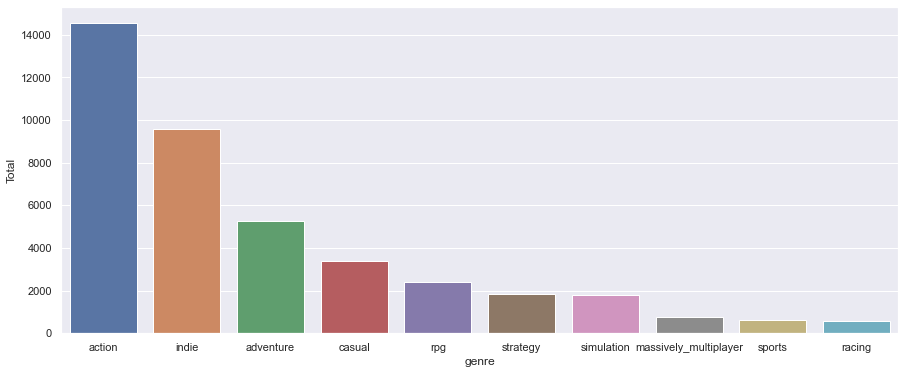

In [25]:
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sb.barplot(x="genre", y="Total", data=steamGenreCount_transposed, ax=ax)

we can see that most of the games' genres are action, indie and adventure. Hence, We can conclude that players are most likely to play these genres compared to the rest.

##### graph to see which genre is most popular 

In [26]:
steamGenre_Date = steamUniqueTitleGenre

In [27]:
#dropping unused columns
steamGenre_Date = steamUniqueTitleGenre[['genre','release_year']]
steamGenre_Date

,genre,release_year
0,Action,2016
1,"Action,Adventure,Massively Multiplayer",2017
2,"Action,Adventure,Strategy",2018
3,"Action,Adventure,Massively Multiplayer",2018
4,"Action,Free to Play,Massively Multiplayer,RPG,...",2003
...,...,...
815,"Action,Indie,Sports",2018
818,"Action,Casual,Indie",2018
825,"Action,Indie",2018
826,"Action,Free to Play,Massively Multiplayer,RPG,...",2019


In [28]:
steamGenre_Date.to_excel("output.xlsx")

##### storing the top 3 genre individually

In [29]:
action =steamGenre_Date.loc[steamGenre_Date['genre'].str.contains("action", case=False)]
indie =steamGenre_Date.loc[steamGenre_Date['genre'].str.contains("indie", case=False)]
adventure = steamGenre_Date.loc[steamGenre_Date['genre'].str.contains("adventure", case=False)]

##### dropping rows that has more than or equal to 2020 and less than 2018 in "release_year" column

In [30]:
# Get names of indexes for which column action has more than or equal to 2020 and drop them
indexAction = action[(action['release_year'] >= 2020)].index
indexAction = action.drop(indexAction , inplace=True)

#Get names of indexes for which column simulation has < 2018 and drop them
indexAction = action[(action['release_year'] < 2008)].index
indexAction = action.drop(indexAction , inplace=True)

# # Get names of indexes for which indie action has more than or equal to 2020 and drop them
indexIndie = indie[(indie['release_year'] >= 2020)].index
indexIndie = indie.drop(indexIndie , inplace=True)

#Get names of indexes for which column simulation has < 2018 and drop them
indexIndie = indie[indie['release_year'] < 2008 ].index
indexIndie = indie.drop(indexIndie , inplace=True)

#Get names of indexes for which column simulation has more than or equal to 2020 and drop them
indexAdventure = adventure[(adventure['release_year'] >= 2020)].index
indexAdventure = adventure.drop(indexAdventure , inplace=True)

#Get names of indexes for which column simulation has < 2018 and drop them
indexAdventure = adventure[adventure['release_year'] < 2008].index
indexAdventure = adventure.drop(indexAdventure , inplace=True)

C:\Users\Pyae Pyae\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Pyae Pyae\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Pyae Pyae\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\Pyae Py

In [31]:
indexAdventure

##### grouping data based on year

In [32]:
groupedAction = action.groupby("release_year").count()
groupedIndie = indie.groupby("release_year").count()
groupedAdventure = adventure.groupby("release_year").count()

#reset index
groupedAction.reset_index(inplace=True)
groupedIndie.reset_index(inplace=True)
groupedAdventure.reset_index(inplace=True)

In [33]:
groupedIndie

,release_year,genre
0,2008,8
1,2009,22
2,2010,29
3,2011,75
4,2012,105
5,2013,163
6,2014,408
7,2015,924
8,2016,1456
9,2017,2087


##### rename and convert the count to corresponding genre

In [34]:
groupedAction = groupedAction.rename(columns={'genre': 'action count'})
groupedAction['action count'] = groupedAction['action count'].astype(int)

groupedIndie = groupedIndie.rename(columns={'genre': 'indie count'}) 
groupedIndie['indie count'] = groupedIndie['indie count'].astype(int)

groupedAdventure = groupedAdventure.rename(columns={'genre': 'adventure count'})
groupedAdventure['adventure count'] = groupedAdventure['adventure count'].astype(int)

In [35]:
groupedAdventure

,release_year,adventure count
0,2008,13
1,2009,14
2,2010,31
3,2011,27
4,2012,63
5,2013,129
6,2014,228
7,2015,501
8,2016,790
9,2017,1134


##### merge the top 3 dataframes into one for lineplot

In [36]:
genreTimeLine = groupedAction.merge(groupedIndie,on='release_year').merge(groupedAdventure,on='release_year')
genreTimeLine

,release_year,action count,indie count,adventure count
0,2008,39,8,13
1,2009,72,22,14
2,2010,119,29,31
3,2011,164,75,27
4,2012,255,105,63
5,2013,411,163,129
6,2014,684,408,228
7,2015,1330,924,501
8,2016,1979,1456,790
9,2017,2860,2087,1134


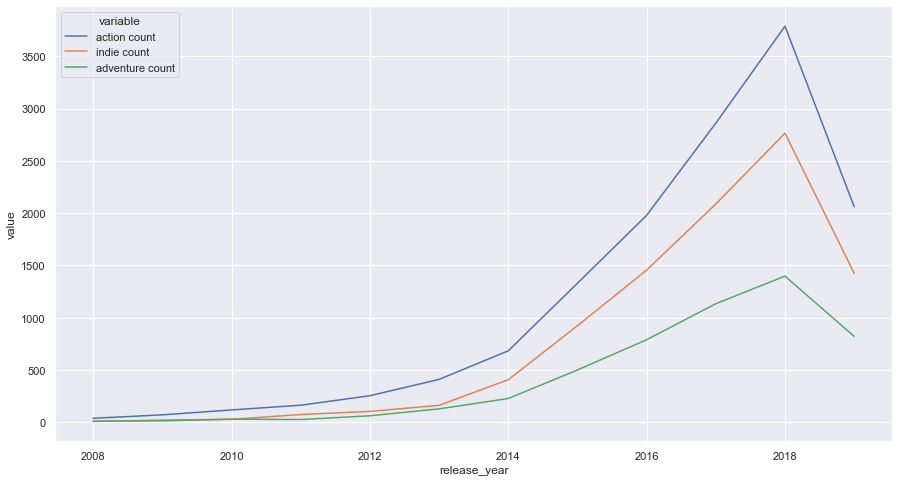

In [37]:
plt.figure(figsize=(15,8))
sb.lineplot(x='release_year', y='value', hue='variable', 
             data=pd.melt(genreTimeLine, ['release_year']))

ya = ax.get_yaxis()
ya.set_major_locator(MaxNLocator(integer=True))

xa = ax.get_xaxis()
xa.set_major_locator(MaxNLocator(integer=True))

plt.show()

We can see that starting from 2014, there is an increase in games release but there is a sharp drop in 2019. 
 
Based on this article, https://gamedaily.biz/article/1489/year-over-year-game-release-numbers-slowed-for-steam-in-2019 , they also said that there is a drop 2019 which is the same as the graph shown above. They mentioned that the drop may be due to the Steam’s notoriously-difficultmarketing and discoverability environment.

### Rating 

In [106]:
steamUniqueTitleRating

,title,genre,release_date,owners,positive_ratings,negative_ratings,price,release_year
0,counter strike,Action,2000-11-01,10000000-20000000,124534,3339,7.19,2000
1,team fortress classic,Action,1999-04-01,5000000-10000000,3318,633,3.99,1999
2,day of defeat,Action,2003-05-01,5000000-10000000,3416,398,3.99,2003
3,deathmatch classic,Action,2001-06-01,5000000-10000000,1273,267,3.99,2001
4,half life opposing force,Action,1999-11-01,5000000-10000000,5250,288,3.99,1999
...,...,...,...,...,...,...,...,...
27070,room of pandora,Adventure;Casual;Indie,2019-04-24,0-20000,3,0,2.09,2019
27071,cyber gun,Action;Adventure;Indie,2019-04-23,0-20000,8,1,1.69,2019
27072,super star blast,Action;Casual;Indie,2019-04-24,0-20000,0,1,3.99,2019
27073,new yankee 7 deer hunters,Adventure;Casual;Indie,2019-04-17,0-20000,2,0,5.19,2019


In [138]:
steamUniqueTitleRating.dtypes

title                       object
genre                       object
release_date        datetime64[ns]
owners                      object
positive_ratings             int64
negative_ratings             int64
price                      float64
release_year                 int64
dtype: object

In [139]:
ratingDF = steamUniqueTitleRating

In [140]:
ratingDF

,title,genre,release_date,owners,positive_ratings,negative_ratings,price,release_year
0,counter strike,Action,2000-11-01,10000000-20000000,124534,3339,7.19,2000
1,team fortress classic,Action,1999-04-01,5000000-10000000,3318,633,3.99,1999
2,day of defeat,Action,2003-05-01,5000000-10000000,3416,398,3.99,2003
3,deathmatch classic,Action,2001-06-01,5000000-10000000,1273,267,3.99,2001
4,half life opposing force,Action,1999-11-01,5000000-10000000,5250,288,3.99,1999
...,...,...,...,...,...,...,...,...
27070,room of pandora,Adventure;Casual;Indie,2019-04-24,0-20000,3,0,2.09,2019
27071,cyber gun,Action;Adventure;Indie,2019-04-23,0-20000,8,1,1.69,2019
27072,super star blast,Action;Casual;Indie,2019-04-24,0-20000,0,1,3.99,2019
27073,new yankee 7 deer hunters,Adventure;Casual;Indie,2019-04-17,0-20000,2,0,5.19,2019


In [141]:
rating_df =ratingDF[(ratingDF['release_year'] < 2020)]

In [142]:
rating_df =ratingDF[(ratingDF['release_year'] > 2017)]

In [143]:
#rating_df.to_excel("output.xlsx")

In [144]:
rating_df=ratingDF[(ratingDF['positive_ratings'] > 500) & (ratingDF['negative_ratings'] > 500)]

In [145]:
rating_df

,title,genre,release_date,owners,positive_ratings,negative_ratings,price,release_year
0,counter strike,Action,2000-11-01,10000000-20000000,124534,3339,7.19,2000
1,team fortress classic,Action,1999-04-01,5000000-10000000,3318,633,3.99,1999
5,ricochet,Action,2000-11-01,5000000-10000000,2758,684,3.99,2000
6,half life,Action,1998-11-08,5000000-10000000,27755,1100,7.19,1998
7,counter strike condition zero,Action,2004-03-01,10000000-20000000,12120,1439,7.19,2004
...,...,...,...,...,...,...,...,...
24992,He Luo Qun Xia Chuan ho tu lo shu : the books ...,RPG;Simulation,2018-11-14,20000-50000,851,593,13.50,2018
25071,Liao Bu Qi De Xiu Xian Mo Ni Qi,Indie;RPG;Simulation;Strategy;Early Access,2019-01-10,200000-500000,2224,1332,14.49,2019
25892,Tan Ling Bi Ji 1v5 notes of soul,Action;Adventure;Indie;Early Access,2019-01-17,200000-500000,4356,601,23.79,2019
25950,Gu Jian Qi Tan San gujian3,RPG,2018-12-14,100000-200000,4945,1035,23.79,2018


##### getting total ratings

In [146]:
def calc_rating(row):
    """Calculate rating score based on SteamDB method."""
    import math

    pos = row['positive_ratings']
    neg = row['negative_ratings']

    total_reviews = pos + neg
    average = pos / total_reviews
    
    # pulls score towards 50, pulls more strongly for games with few reviews
    score = average - (average*0.5) * 2**(-np.log10(total_reviews + 1))

    return score * 100

In [147]:
#steamUniqueTitleRating['owners'] = steamUniqueTitleRating['owners'].str.split('-').apply(lambda x: x[0]).astype(int)

In [148]:
rating_df["rating"] = ""

<ipython-input-148-224db86d00a0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df["rating"] = ""


In [149]:
#ratingDF['rating'] = ratingDF.apply(calc_rating, axis=1)

In [150]:
rating_df

,title,genre,release_date,owners,positive_ratings,negative_ratings,price,release_year,rating
0,counter strike,Action,2000-11-01,10000000-20000000,124534,3339,7.19,2000,
1,team fortress classic,Action,1999-04-01,5000000-10000000,3318,633,3.99,1999,
5,ricochet,Action,2000-11-01,5000000-10000000,2758,684,3.99,2000,
6,half life,Action,1998-11-08,5000000-10000000,27755,1100,7.19,1998,
7,counter strike condition zero,Action,2004-03-01,10000000-20000000,12120,1439,7.19,2004,
...,...,...,...,...,...,...,...,...,...
24992,He Luo Qun Xia Chuan ho tu lo shu : the books ...,RPG;Simulation,2018-11-14,20000-50000,851,593,13.50,2018,
25071,Liao Bu Qi De Xiu Xian Mo Ni Qi,Indie;RPG;Simulation;Strategy;Early Access,2019-01-10,200000-500000,2224,1332,14.49,2019,
25892,Tan Ling Bi Ji 1v5 notes of soul,Action;Adventure;Indie;Early Access,2019-01-17,200000-500000,4356,601,23.79,2019,
25950,Gu Jian Qi Tan San gujian3,RPG,2018-12-14,100000-200000,4945,1035,23.79,2018,


In [151]:
#keep lower bound of owners column, as integer
rating_df['owners'] = rating_df['owners'].str.split('-').apply(lambda x: x[0]).astype(int)

# calculate rating, as well as simple ratio for comparison
rating_df['total_ratings'] = rating_df['positive_ratings'] + rating_df['negative_ratings']
rating_df['rating_ratio'] = rating_df['positive_ratings'] / rating_df['total_ratings']
rating_df['rating'] = rating_df.apply(calc_rating, axis=1)
#ratingDF['rating'] = ratingDF.apply(calc_rating)
    
# convert release_date to datetime type and create separate column for release_year
# ratingDF['release_date'] = ratingDF['release_date'].astype('datetime64[ns]')
# ratingDF['release_year'] = ratingDF['release_date'].apply(lambda x: x.year) 

<ipython-input-151-ddfc4d1faefc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df['owners'] = rating_df['owners'].str.split('-').apply(lambda x: x[0]).astype(int)
<ipython-input-151-ddfc4d1faefc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_df['total_ratings'] = rating_df['positive_ratings'] + rating_df['negative_ratings']
<ipython-input-151-ddfc4d1faefc>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [158]:
rating_df[rating_df["price"] == 0]

,title,genre,release_date,owners,positive_ratings,negative_ratings,price,release_year,rating,total_ratings,rating_ratio,type
11,half life source,Action,2004-06-01,2000000,3767,1053,0.0,2004,75.111355,4820,0.781535,Free
14,half life 2 lost coast,Action,2005-10-27,10000000,5783,1020,0.0,2005,82.023667,6803,0.850066,Free
19,team fortress 2,Action;Free to Play,2007-10-10,20000000,515879,34036,0.0,2007,92.933233,549915,0.938107,Free
22,dota 2,Action;Free to Play;Strategy,2013-07-09,100000000,863507,142079,0.0,2013,85.201281,1005586,0.858710,Free
24,alien swarm,Action,2010-07-19,2000000,17435,941,0.0,2010,92.410501,18376,0.948792,Free
...,...,...,...,...,...,...,...,...,...,...,...,...
23163,cuisine royale,Action;Free to Play;Massively Multiplayer;Earl...,2018-06-15,1000000,9657,2964,0.0,2018,74.286096,12621,0.765153,Free
23449,creative destruction,Action;Adventure;Casual;Massively Multiplayer,2018-08-02,500000,4323,1127,0.0,2018,76.345550,5450,0.793211,Free
24165,modern combat 5,Action;Free to Play;Massively Multiplayer,2018-10-24,200000,589,774,0.0,2018,40.753606,1363,0.432135,Free
24173,dissidia final fantasy nt free edition,Action;Free to Play,2019-03-12,200000,620,1005,0.0,2019,36.093858,1625,0.381538,Free


C:\Users\Pyae Pyae\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


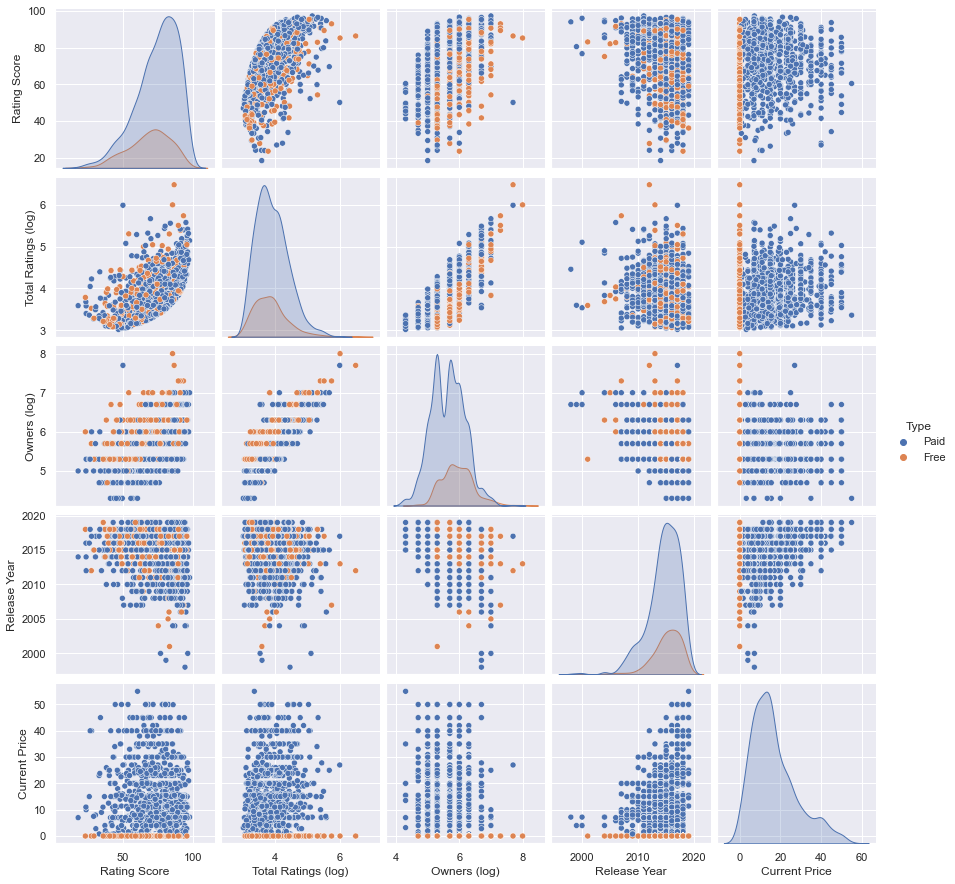

In [161]:
# Create a column to split free vs paid games
rating_df['type'] = 'Free'
rating_df.loc[rating_df['price'] > 0, 'type'] = 'Paid'

# ensure no 0s in columns we're applying log to
df = rating_df[(rating_df['owners'] > 0) & (rating_df['total_ratings'] > 0)].copy()

eda_df = pd.DataFrame(zip(df['rating'],
                          np.log10(df['total_ratings']),
                          np.log10(df['owners']),
                          df['release_year'],
                          df.price,
                          df['type']
                         ),
                      columns=['Rating Score', 'Total Ratings (log)', 'Owners (log)', 'Release Year', 'Current Price', 'Type'])

sb.pairplot(eda_df, hue='Type')
plt.show()

We can see that: 
- paid games look to have higher ratings on average than free games
- there are more owners for paid than free games
- more ratings are given to paid games than free ones
- the more owners of a game, the higher ratings it has
- more recent games are more expensive

We can conclude that:
- As price increases, rating increases, so it's possible people are more likely to rate a game highly if they have spent more money on purchasing it. 
- The more owners of a game, the more ratings it has. This suggests that the better rated a game, the more people buy it

In [163]:
action = rating_df.loc[rating_df['genre'].str.contains("action", case=False)]
indie =rating_df.loc[rating_df['genre'].str.contains("indie", case=False)]
simulation = rating_df.loc[rating_df['genre'].str.contains("simulation", case=False)]
strategy = rating_df.loc[rating_df['genre'].str.contains("strategy", case=False)]
rpg = rating_df.loc[ratingDF['genre'].str.contains("rpg", case=False)]
sports = rating_df.loc[rating_df['genre'].str.contains("sports", case=False)]
racing = rating_df.loc[rating_df['genre'].str.contains("racing", case=False)]
casual = rating_df.loc[rating_df['genre'].str.contains("casual", case=False)]
massively_multiplayer = rating_df.loc[rating_df['genre'].str.contains("massively multiplayer", case=False)]
adventure = rating_df.loc[rating_df['genre'].str.contains("adventure", case=False)]

##### summing all the postive rating and negative rating separately

In [164]:
#action
action_posRating = action['positive_ratings'].sum()    
action_negRating = action['negative_ratings'].sum() 

#indie
indie_posRating = indie['positive_ratings'].sum()    
indie_negRating = indie['negative_ratings'].sum()  

#simulation
simulation_posRating = simulation['positive_ratings'].sum()    
simulation_negRating = simulation['negative_ratings'].sum() 

#strategy
strategy_posRating = strategy['positive_ratings'].sum()    
strategy_negRating = strategy['negative_ratings'].sum()

#rpg
rpg_posRating = rpg['positive_ratings'].sum()    
rpg_negRating = rpg['negative_ratings'].sum()

#sports
sports_posRating = sports['positive_ratings'].sum()    
sports_negRating = sports['negative_ratings'].sum()

#racing
racing_posRating = racing['positive_ratings'].sum()    
racing_negRating = racing['negative_ratings'].sum()

#casual
casual_posRating = casual['positive_ratings'].sum()    
casual_negRating = casual['negative_ratings'].sum()

#massively_multiplayer
massively_multiplayer_posRating = massively_multiplayer['positive_ratings'].sum()    
massively_multiplayer_negRating = massively_multiplayer['negative_ratings'].sum()

#adventure
adventure_posRating = adventure['positive_ratings'].sum()    
adventure_negRating = adventure['negative_ratings'].sum()

In [165]:
# initialize data of lists.
data = {'genre':['action', 'indie', 'simulation', 'strategy', 'rpg', 'sports', 'racing', 'casual', 'massively_multiplayer', 'adventure'],
        'positive_ratings':[action_posRating, indie_posRating, simulation_posRating, strategy_posRating, rpg_posRating, sports_posRating, racing_posRating, casual_posRating, massively_multiplayer_posRating, adventure_posRating],
        'negative_ratings':[action_negRating, indie_negRating, simulation_negRating, strategy_negRating, rpg_negRating, sports_negRating, racing_negRating, casual_negRating, massively_multiplayer_negRating, adventure_negRating]
       }
  
# Create DataFrame
genreRating = pd.DataFrame(data)

In [166]:
#sum_column = genreRating["positive_ratings"] + genreRating["negative_ratings"]
#genreRating["total_ratings"] = sum_column

In [167]:
genreRating = genreRating.set_index('genre')

In [168]:
genreRating = genreRating.div(genreRating.sum(axis=1), axis=0)*100

Text(0.5, 0, 'rating in percentage')

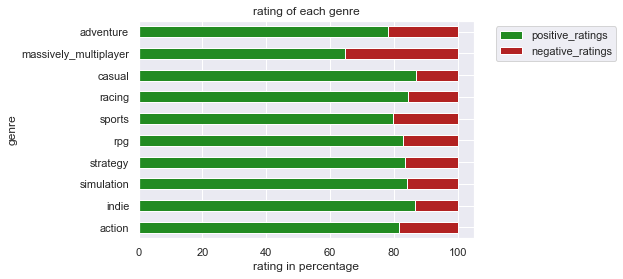

In [169]:
genreRating..sort_values(by='a',ascending=False).plot(kind = 'barh', stacked = True, color=("forestgreen","firebrick"))
plt.legend(bbox_to_anchor=(1.05,1))
plt.title("rating of each genre")
plt.xlabel("rating in percentage")

we can see that simulation and indie have a lot more postive ratings compared to the rest. We thought that action would receive more postive rating as it is considered the most popular genre. The reason why simulation and indie has more postive rating may be due to factors such as lenghth of game play and content of the game which we will explore later.

### Reviews

In [ ]:
cleanReviewsTitle

In [ ]:
NUM_TOP_WORDS = 10

top_10 = hero.visualization.top_words(cleanReviewsTitle['clean_review']).head(NUM_TOP_WORDS)

# Draw the bar chart

top_10.plot.bar(rot=90, title="Top 10 words");

plt.show(block=True);


In [ ]:
hero.wordcloud(cleanReviewsTitle['clean_review'], max_words=200,)

Some popular words that can be observed here include “good,” “fun" and "great". Also, there are some negative words such
as "bad" and "bugs". However, there are more postivive word, indicating that most reviews in the dataset express a positive sentiment.

In [ ]:
cleanReviewsTitle

In [ ]:
cleanReviewsTitle.loc[cleanReviewsTitle['voted_up'] == True, 'sentimental'] = 1
cleanReviewsTitle.loc[cleanReviewsTitle['voted_up'] == False, 'sentimental'] = -1

In [ ]:
cleanReviewsTitle.dtypes

In [ ]:
cleanReviewsTitle['sentimental'] = cleanReviewsTitle['sentimental'].astype(int)

In [ ]:
cleanReviewsTitle

In [ ]:
positive = cleanReviewsTitle[cleanReviewsTitle['sentimental'] == 1]
negative = cleanReviewsTitle[cleanReviewsTitle['sentimental'] == -1]

In [ ]:
negative

In [ ]:
hero.wordcloud(negative['clean_review'], max_words=100,)

This shows the word cloud for all words appeared in reviews that are voted down. We can see that even if they are voted down, there are still some postivie words such as "good" and "fun". However, we also see some negative words such as "bad", "nothing" and "bugs". We also see words such as money and hours. 

From here we can assume that the games were voted down due to long hour play, havings bugs and not worth the money.

In [ ]:
new_cleanReviewsTitle = cleanReviewsTitle[['clean_review','sentimental']]

In [ ]:
new_cleanReviewsTitle

In [ ]:
#random split train and test data
# index = df.index
# df['random_number'] = np.random.randn(len(index))
# train = df[df['random_number'] <= 0.8]
# test = df[df['random_number'] > 0.8]